In [72]:
!pip install pyspark
!pip install findspark  
!pip install pandas
!pip install -U scikit-learn
!pip install -U matplotlib
!pip install treeplot

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached treeplot-0.1.16-py3-none-any.whl (8.7 kB)
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)
  Using cached funcsigs-1.0.2-py2.py3-none-any.whl (17 kB)
  Using cached wget-3.2.zip (10 kB)
  Preparing metadata (setup.py) ... done
  Using cached sklearn-0.0.post1.tar.gz (3.6 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=cb3e6627ab9ef8c0bf1fa2951d0bd2c88bfaab466fe5756fe31ebb6ad8f8e091
  Stored in directory: /home/sepay/.ca

In [3]:
from pyspark.sql import SparkSession
import findspark
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import * 
from pyspark.sql.types import StringType,BooleanType,DateType, IntegerType  
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
from pyspark.sql import SQLContext
from sklearn.metrics import confusion_matrix


findspark.init()

spark = SparkSession.builder.appName("Pyspark Tutorial")\
                    .config("spark.memory.offHeap.enabled","true")\
                    .config("spark.memory.offHeap.size","10g")\
                    .getOrCreate()


# check spark configuration

spark

23/01/20 20:42:35 WARN Utils: Your hostname, sepay-HP resolves to a loopback address: 127.0.1.1; using 192.168.1.31 instead (on interface wlo1)
23/01/20 20:42:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/20 20:42:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
!curl https://raw.githubusercontent.com/Sepay/Programming/main/obesity.csv >> obesity.csv
    
df = spark.read.csv('obesity.csv',header=True,sep=",")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  257k  100  257k    0     0  1391k      0 --:--:-- --:--:-- --:--:-- 1399k


In [5]:
df = df.withColumnRenamed('family_history_with_overweight', 'FH')

In [394]:
df.show(5,0)

+------+---+------+------+---+----+----+---+---------+-----+----+---+---+---+----------+---------------------+-------------------+
|Gender|Age|Height|Weight|FH |FAVC|FCVC|NCP|CAEC     |SMOKE|CH2O|SCC|FAF|TUE|CALC      |MTRANS               |NObeyesdad         |
+------+---+------+------+---+----+----+---+---------+-----+----+---+---+---+----------+---------------------+-------------------+
|Female|21 |1.62  |64    |yes|no  |2   |3  |Sometimes|no   |2   |no |0  |1  |no        |Public_Transportation|Normal_Weight      |
|Female|21 |1.52  |56    |yes|no  |3   |3  |Sometimes|yes  |3   |yes|3  |0  |Sometimes |Public_Transportation|Normal_Weight      |
|Male  |23 |1.8   |77    |yes|no  |2   |3  |Sometimes|no   |2   |no |2  |1  |Frequently|Public_Transportation|Normal_Weight      |
|Male  |27 |1.8   |87    |no |no  |3   |3  |Sometimes|no   |2   |no |2  |0  |Frequently|Walking              |Overweight_Level_I |
|Male  |22 |1.78  |89.8  |no |no  |2   |1  |Sometimes|no   |2   |no |0  |0  |Someti

In [395]:
df.count()

50687

In [396]:
df= df.drop('TUE')

In [397]:
df.show()

+------+---+------+------+---+----+----+---+----------+-----+----+---+---+----------+--------------------+-------------------+
|Gender|Age|Height|Weight| FH|FAVC|FCVC|NCP|      CAEC|SMOKE|CH2O|SCC|FAF|      CALC|              MTRANS|         NObeyesdad|
+------+---+------+------+---+----+----+---+----------+-----+----+---+---+----------+--------------------+-------------------+
|Female| 21|  1.62|    64|yes|  no|   2|  3| Sometimes|   no|   2| no|  0|        no|Public_Transporta...|      Normal_Weight|
|Female| 21|  1.52|    56|yes|  no|   3|  3| Sometimes|  yes|   3|yes|  3| Sometimes|Public_Transporta...|      Normal_Weight|
|  Male| 23|   1.8|    77|yes|  no|   2|  3| Sometimes|   no|   2| no|  2|Frequently|Public_Transporta...|      Normal_Weight|
|  Male| 27|   1.8|    87| no|  no|   3|  3| Sometimes|   no|   2| no|  2|Frequently|             Walking| Overweight_Level_I|
|  Male| 22|  1.78|  89.8| no|  no|   2|  1| Sometimes|   no|   2| no|  0| Sometimes|Public_Transporta...|Overw

# Variáveis

Retirou-se a coluna dos telemoveis 

# TRATAMENTO DE DADOS

Alterou-se as colunas Gender, FH, CAEC, SMOLE, SCC, CALC, MTRANS, OBESITY para inteiros para ser mais facil executar os algoritmos


In [398]:
df.groupBy('NObeyesdad').count().show()

+-------------------+-----+
|         NObeyesdad|count|
+-------------------+-----+
|   Obesity_Type_III| 7776|
| Overweight_Level_I| 6960|
|    Obesity_Type_II| 7128|
|Insufficient_Weight| 6528|
|Overweight_Level_II| 6960|
|      Normal_Weight| 6888|
|         NObeyesdad|   23|
|     Obesity_Type_I| 8424|
+-------------------+-----+



In [399]:
df = df.withColumn("CAEC", when(col("CAEC")== "Sometimes", 0).when(col("CAEC") == "Frequently", 1).otherwise(2))
df = df.withColumn("Gender", when(col("Gender")== "Female", 0).otherwise(1))
df = df.withColumn("FH", when(col("FH")== "yes", 0).otherwise(1))
df = df.withColumn("FAVC", when(col("FAVC")== "yes", 0).otherwise(1))
df = df.withColumn("SMOKE", when(col("SMOKE")== "yes", 0).otherwise(1))
df = df.withColumn("SCC", when(col("SCC")== "yes", 0).otherwise(1))
df = df.withColumn("CALC", when(col("CALC")== "no", 0).when(col("CALC") == "Sometimes", 1).when(col("CALC")=="Frequently", 2).otherwise(3))
df = df.withColumn("MTRANS", when(col("MTRANS")== "Public_Transportation", 0).when(col("MTRANS") == "Automobile", 0).when(col("MTRANS")=="Motorbike", 0).otherwise(1))
df = df.withColumn("NObeyesdad", when(col("NObeyesdad")== "Insufficient_Weight", 0).when(col("NObeyesdad") == "Normal_Weight", 0).when(col("NObeyesdad")=="Overweight_Level_I", 0).when(col("NObeyesdad")== "Overweight_Level_II",0).otherwise(1))

In [400]:
df = df.withColumnRenamed("family_history_with_overweight","Family_HIST")
df = df.withColumnRenamed('FAVC','CALORICFOOD')
df=df.withColumnRenamed('Gender','GENDER')
df=df.withColumnRenamed('Age','AGE')
df=df.withColumnRenamed('Weight','WEIGHT')
df=df.withColumnRenamed('Height','HEIGHT')
df=df.withColumnRenamed('FCVC','VEGET')
df=df.withColumnRenamed('NCP','MEALS')
df=df.withColumnRenamed('CAEC','BETWEENMEALS')
df=df.withColumnRenamed('CH2O','H20')
df=df.withColumnRenamed('SCC','CALORIES')
df=df.withColumnRenamed('FAF','PHYSY')
df=df.withColumnRenamed('CALC','ALCH')
df=df.withColumnRenamed('MTRANS','TRANSPORT')
df=df.withColumnRenamed('NObeyesdad','OBESITY')

In [401]:
df.show()

+------+---+------+------+---+-----------+-----+-----+------------+-----+---+--------+-----+----+---------+-------+
|GENDER|AGE|HEIGHT|WEIGHT| FH|CALORICFOOD|VEGET|MEALS|BETWEENMEALS|SMOKE|H20|CALORIES|PHYSY|ALCH|TRANSPORT|OBESITY|
+------+---+------+------+---+-----------+-----+-----+------------+-----+---+--------+-----+----+---------+-------+
|     0| 21|  1.62|    64|  0|          1|    2|    3|           0|    1|  2|       1|    0|   0|        0|      0|
|     0| 21|  1.52|    56|  0|          1|    3|    3|           0|    0|  3|       0|    3|   1|        0|      0|
|     1| 23|   1.8|    77|  0|          1|    2|    3|           0|    1|  2|       1|    2|   2|        0|      0|
|     1| 27|   1.8|    87|  1|          1|    3|    3|           0|    1|  2|       1|    2|   2|        1|      0|
|     1| 22|  1.78|  89.8|  1|          1|    2|    1|           0|    1|  2|       1|    0|   1|        0|      0|
|     1| 29|  1.62|    53|  1|          0|    2|    3|           0|    1

Converter tudo para int

In [402]:

df = df.withColumn("VEGET",col("VEGET").cast(IntegerType())) \
    .withColumn("MEALS",col("MEALS").cast(IntegerType())) \
    .withColumn("H20",col("H20").cast(IntegerType())) \
    .withColumn("PHYSY",col("PHYSY").cast(IntegerType()))
df = df.fillna(0)
df.printSchema()

root
 |-- GENDER: integer (nullable = false)
 |-- AGE: string (nullable = true)
 |-- HEIGHT: string (nullable = true)
 |-- WEIGHT: string (nullable = true)
 |-- FH: integer (nullable = false)
 |-- CALORICFOOD: integer (nullable = false)
 |-- VEGET: integer (nullable = true)
 |-- MEALS: integer (nullable = true)
 |-- BETWEENMEALS: integer (nullable = false)
 |-- SMOKE: integer (nullable = false)
 |-- H20: integer (nullable = true)
 |-- CALORIES: integer (nullable = false)
 |-- PHYSY: integer (nullable = true)
 |-- ALCH: integer (nullable = false)
 |-- TRANSPORT: integer (nullable = false)
 |-- OBESITY: integer (nullable = false)



In [403]:

assemble=VectorAssembler(inputCols=[
    'FH','CALORICFOOD', "SMOKE", "VEGET", "MEALS", 
    "BETWEENMEALS", "H20", "CALORIES", "PHYSY", "ALCH"
], outputCol='features')

In [404]:
assembled_data=assemble.transform(df)

In [405]:
scale=StandardScaler(inputCol='features',outputCol='standardized')
scale=scale.fit(assembled_data)
scale_output= scale.transform(assembled_data)

scale_output.select('standardized').show(2,truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------+
|standardized                                                                                                                     |
+---------------------------------------------------------------------------------------------------------------------------------+
|[0.0,3.1174139264350265,7.0013829302752075,3.3279192420385355,3.607287568555658,0.0,3.3355685189839885,4.800701126695684,0.0,0.0]|
|[0.0,3.1174139264350265,0.0,4.991878863057803,3.607287568555658,0.0,5.003352778475983,0.0,3.6032529914271225,1.9322764849183296] |
+---------------------------------------------------------------------------------------------------------------------------------+
only showing top 2 rows



In [406]:
finalData = scale_output.select("features", "OBESITY")
train, test =finalData.randomSplit([0.8,0.2])

In [407]:

lr = LogisticRegression(featuresCol="features" ,labelCol="OBESITY", maxIter=5)
lrModel = lr.fit(train)

In [408]:
predictions = lrModel.transform(test)
predictions.select("OBESITY", "features", "rawPrediction", "prediction", "probability").toPandas().head(5)

,OBESITY,features,rawPrediction,prediction,probability
0,0,"(1.0, 0.0, 1.0, 3.0, 2.0, 0.0, 2.0, 0.0, 0.0, ...","[4.3040995446584525, -4.3040995446584525]",0.0,"[0.9866671198870884, 0.01333288011291156]"
1,0,"(1.0, 0.0, 1.0, 3.0, 2.0, 0.0, 2.0, 0.0, 0.0, ...","[4.3040995446584525, -4.3040995446584525]",0.0,"[0.9866671198870884, 0.01333288011291156]"
2,0,"(1.0, 0.0, 1.0, 3.0, 2.0, 0.0, 2.0, 0.0, 0.0, ...","[4.3040995446584525, -4.3040995446584525]",0.0,"[0.9866671198870884, 0.01333288011291156]"
3,0,"(1.0, 0.0, 1.0, 3.0, 2.0, 0.0, 2.0, 0.0, 0.0, ...","[4.3040995446584525, -4.3040995446584525]",0.0,"[0.9866671198870884, 0.01333288011291156]"
4,1,"(0.0, 1.0, 0.0, 2.0, 3.0, 0.0, 3.0, 1.0, 0.0, ...","[0.48970737826501254, -0.48970737826501254]",0.0,"[0.6200374957179643, 0.3799625042820357]"


In [409]:


eval = BinaryClassificationEvaluator(rawPredictionCol = "prediction", labelCol = "OBESITY")
auc = eval.evaluate(predictions)
print(auc)

0.7682251814638306


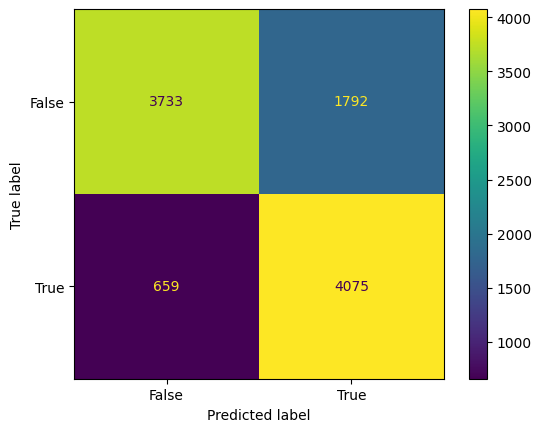

In [410]:
from sklearn import metrics
y_true = predictions.select("OBESITY")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnfMatrix = confusion_matrix(y_true, y_pred)


cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cnfMatrix, display_labels = [False, True])
cm_display.plot()
plt.show() 

In [411]:
FP = predictions.where(predictions["OBESITY"] == predictions["prediction"]).count()
accuracy = FP /float(predictions.count())
accuracy

0.7610878253241057

Text(0, 0.5, 'True Positive Rate')

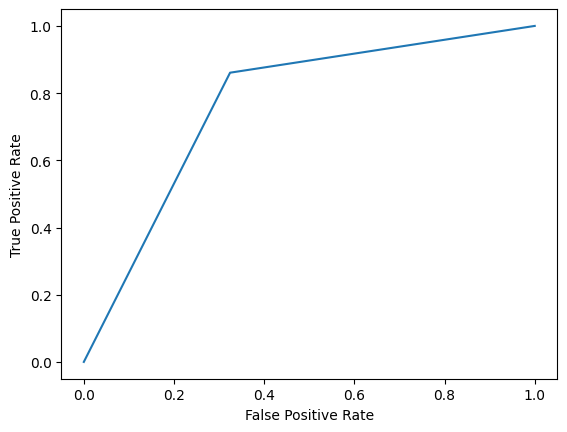

In [412]:
from pyspark.conf import SparkConf

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')



In [413]:
paramGrid = ParamGridBuilder()\
            .addGrid(lr.regParam, [0.01,0.5,2.0])\
            .addGrid(lr.elasticNetParam, [0.0,0.5,1.0])\
            .addGrid(lr.maxIter, [1,5,10])\
            .build()


In [414]:
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid,
                    evaluator=eval, numFolds=5 , parallelism=4)

In [415]:
cvModel = cv.fit(train)

In [416]:
predictions_cv = cvModel.transform(test)
eval.evaluate(predictions_cv)

0.7742903650687145

In [417]:
FP = predictions_cv.where(predictions_cv["OBESITY"] == predictions_cv["prediction"]).count()
accuracy = FP /float(predictions_cv.count())
accuracy

0.7668388731845209

### Decision trees

In [16]:
!curl https://raw.githubusercontent.com/Sepay/Programming/main/obesity.csv >> obesity.csv
    
df_knn = spark.read.csv('obesity.csv',header=True,sep=",")
df_knn.show()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  257k  100  257k    0     0  1714k      0 --:--:-- --:--:-- --:--:-- 1705k
+------+---+------+------+------------------------------+----+----+---+----------+-----+----+---+---+---+----------+--------------------+-------------------+
|Gender|Age|Height|Weight|family_history_with_overweight|FAVC|FCVC|NCP|      CAEC|SMOKE|CH2O|SCC|FAF|TUE|      CALC|              MTRANS|         NObeyesdad|
+------+---+------+------+------------------------------+----+----+---+----------+-----+----+---+---+---+----------+--------------------+-------------------+
|Female| 21|  1.62|    64|                           yes|  no|   2|  3| Sometimes|   no|   2| no|  0|  1|        no|Public_Transporta...|      Normal_Weight|
|Female| 21|  1.52|    56|                           yes|  no|   3|  3| Sometimes|  yes|   3|yes|  3|  0| Sometimes|Public_Transpor

In [19]:
df_knn = df_knn.drop('TUE')
df_knn = df_knn.withColumn("CAEC", when(col("CAEC")== "Sometimes", 0).when(col("CAEC") == "Frequently", 1).otherwise(2))
df_knn = df_knn.withColumn("Gender", when(col("Gender")== "Female", 0).otherwise(1))
df_knn = df_knn.withColumn("family_history_with_overweight", when(col("family_history_with_overweight")== "yes", 0).otherwise(1))
df_knn = df_knn.withColumn("FAVC", when(col("FAVC")== "yes", 0).otherwise(1))
df_knn = df_knn.withColumn("SMOKE", when(col("SMOKE")== "yes", 0).otherwise(1))
df_knn = df_knn.withColumn("SCC", when(col("SCC")== "yes", 0).otherwise(1))
df_knn = df_knn.withColumn("CALC", when(col("CALC")== "no", 0).when(col("CALC") == "Sometimes", 1).when(col("CALC")=="Frequently", 2).otherwise(3))
df_knn = df_knn.withColumn("MTRANS", when(col("MTRANS")== "Public_Transportation", 0).when(col("MTRANS") == "Automobile", 0).when(col("MTRANS")=="Motorbike", 0).otherwise(1))
df_knn = df_knn.withColumn("NObeyesdad", when(col("NObeyesdad")== "Insufficient_Weight", 1).when(col("NObeyesdad") == "Normal_Weight", 2).when(col("NObeyesdad")=="Overweight_Level_I", 3).when(col("NObeyesdad")== "Overweight_Level_II",4).when(col("NObeyesdad")=="Obesity_Type_I", 5).otherwise(6))

In [20]:
df_knn=df_knn.withColumnRenamed("family_history_with_overweight","FH")
df_knn=df_knn.withColumnRenamed('FAVC','CALORICFOOD')
df_knn=df_knn.withColumnRenamed('Gender','GENDER')
df_knn=df_knn.withColumnRenamed('Age','AGE')
df_knn=df_knn.withColumnRenamed('Weight','WEIGHT')
df_knn=df_knn.withColumnRenamed('Height','HEIGHT')
df_knn=df_knn.withColumnRenamed('FCVC','VEGET')
df_knn=df_knn.withColumnRenamed('NCP','MEALS')
df_knn=df_knn.withColumnRenamed('CAEC','BETWEENMEALS')
df_knn=df_knn.withColumnRenamed('CH2O','H20')
df_knn=df_knn.withColumnRenamed('SCC','CALORIES')
df_knn=df_knn.withColumnRenamed('FAF','PHYSY')
df_knn=df_knn.withColumnRenamed('CALC','ALCH')
df_knn=df_knn.withColumnRenamed('MTRANS','TRANSPORT')
df_knn=df_knn.withColumnRenamed('NObeyesdad','OBESITY')

In [50]:
df_knn = df_knn.withColumn("VEGET",col("VEGET").cast(IntegerType())) \
    .withColumn("MEALS",col("MEALS").cast(IntegerType())) \
    .withColumn("H20",col("H20").cast(IntegerType())) \
    .withColumn("PHYSY",col("PHYSY").cast(IntegerType()))\
    .withColumn("AGE",col("AGE").cast(IntegerType()))\
    .withColumn("WEIGHT",col("WEIGHT").cast(IntegerType()))
df_knn = df_knn.dropna()
df_knn.printSchema()

root
 |-- GENDER: integer (nullable = false)
 |-- AGE: integer (nullable = true)
 |-- HEIGHT: string (nullable = true)
 |-- WEIGHT: integer (nullable = true)
 |-- FH: integer (nullable = false)
 |-- CALORICFOOD: integer (nullable = false)
 |-- VEGET: integer (nullable = true)
 |-- MEALS: integer (nullable = true)
 |-- BETWEENMEALS: integer (nullable = false)
 |-- SMOKE: integer (nullable = false)
 |-- H20: integer (nullable = true)
 |-- CALORIES: integer (nullable = false)
 |-- PHYSY: integer (nullable = true)
 |-- ALCH: integer (nullable = false)
 |-- TRANSPORT: integer (nullable = false)
 |-- OBESITY: integer (nullable = false)



In [51]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [52]:
assembleTree=VectorAssembler(inputCols=[
    'FH','CALORICFOOD', "SMOKE",
    "VEGET", "MEALS", "BETWEENMEALS",
    "H20", "CALORIES", "PHYSY",
    "ALCH", "GENDER", "AGE",
    "WEIGHT"
], outputCol='features')

In [53]:
assembledTree_data=assembleTree.transform(df_knn)

In [54]:
scale=StandardScaler(inputCol='features',outputCol='standardized')
scale=scale.fit(assembledTree_data)
scale_outputTree= scale.transform(assembledTree_data)

scale_outputTree.select('standardized').show(2,truncate=False)

finalDataTree = scale_outputTree.select("features", "OBESITY")
trainT, testT =finalDataTree.randomSplit([0.8,0.2])

23/01/20 21:23:13 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|standardized                                                                                                                                                           |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[0.0,3.1220929193250346,6.9998399435208185,3.337450195029862,3.614028981142659,0.0,3.341003336033181,4.799671833031942,0.0,0.0,0.0,3.329516881505676,2.454105973422261]|
|[0.0,3.1220929193250346,0.0,5.006175292544793,3.614028981142659,0.0,5.011505004049772,0.0,3.603077880219743,1.940315268461313,0.0,3.3295168

In [93]:
deciTree = DecisionTreeClassifier(featuresCol="features", labelCol="OBESITY")
deciTree = deciTree.fit(trainT)

predTree = deciTree.transform(testT)
predTree.show()

+--------------------+-------+--------------------+--------------------+----------+
|            features|OBESITY|       rawPrediction|         probability|prediction|
+--------------------+-------+--------------------+--------------------+----------+
|[0.0,0.0,0.0,1.0,...|      6|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|       6.0|
|[0.0,0.0,0.0,1.0,...|      6|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|       6.0|
|[0.0,0.0,0.0,2.0,...|      4|[0.0,0.0,1369.0,3...|[0.0,0.0,0.281571...|       3.0|
|[0.0,0.0,0.0,2.0,...|      4|[0.0,0.0,1369.0,3...|[0.0,0.0,0.281571...|       3.0|
|[0.0,0.0,0.0,2.0,...|      4|[0.0,0.0,1369.0,3...|[0.0,0.0,0.281571...|       3.0|
|[0.0,0.0,0.0,2.0,...|      3|[0.0,0.0,1369.0,3...|[0.0,0.0,0.281571...|       3.0|
|[0.0,0.0,0.0,2.0,...|      5|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|       5.0|
|[0.0,0.0,0.0,2.0,...|      5|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|       5.0|
|[0.0,0.0,0.0,2.0,...|      5|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|    

In [80]:
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="OBESITY")
acc = evaluator.evaluate(predTree) 
print(acc)

0.7413719647563415


In [81]:
y_pred=predTree.select("prediction").collect()
y_orig=predTree.select("OBESITY").collect()

In [82]:

cmTree = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cmTree)


Confusion Matrix:
[[1364  275    0    0    0    0]
 [ 241  834  387  158    0    0]
 [   0  150 1199  403    0    0]
 [   0   47  196 1395   12   34]
 [   0    0  102  968  808  119]
 [   0    0    0    0   20 3516]]


In [ ]:
#Desenhar a matriz